## Importing libraries

In [1]:
import os
import cv2
import json
import pandas as pd
from tqdm import tqdm
import mediapipe as mp
from random import sample
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

HOME = os.getcwd()
os.chdir(HOME)

ann_dir = './data/annos'
img_dir = './data/image'

## Dataset Structure
* data
  * annos
    * 000001.json
    * 000002.json
  * image
    * 000001.jpg
    * 000002.jpg

## Basic functions

In [2]:
# initializing blaze pose model
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

In [3]:
def is_full_shot(results):
    '''Check whether the image is full shot or not.'''
    right_ankle = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ANKLE]
    left_ankle = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ANKLE]
    nose = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE]
    min_conf = 0.5

    if (
        right_ankle.visibility > min_conf
        and left_ankle.visibility > min_conf
        and nose.visibility > min_conf
    ):
        return True
    else:
        return False

In [4]:
def relevant_info(data):
    '''Returns only relevant info from input data.'''
    dictionary = dict()
    for key in data.keys():
        if "item" in key:
            dictionary[key] = {
                "bounding_box": data[key]["bounding_box"],
                "category_id": data[key]["category_id"],
                "category_name": data[key]["category_name"],
            }
    return dictionary

In [5]:
# Updating Json
for ann in tqdm(os.listdir(ann_dir)):
    with open(os.path.join(ann_dir, ann), "r") as file:
        data = json.load(file)
        data = relevant_info(data)

    with open(os.path.join(ann_dir, ann), "w") as file:
        json.dump(data, file, indent=4)

print("All annotation files updates!")

100%|██████████| 32153/32153 [00:43<00:00, 735.31it/s]

All annotation files updates!


## Annotations

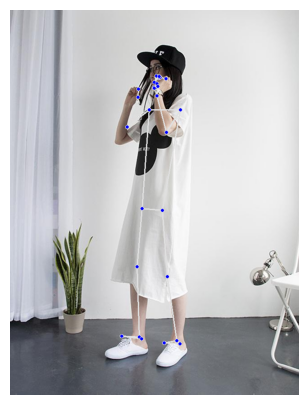

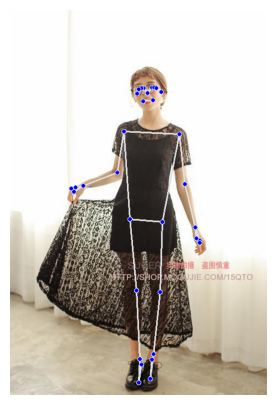

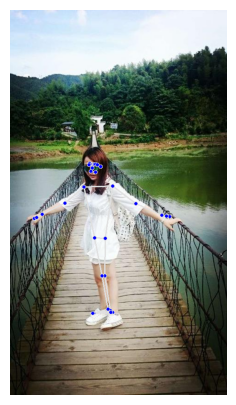

In [6]:
num = 5
min_conf = 0.5

with mp_pose.Pose(static_image_mode=True, min_detection_confidence=min_conf) as pose:
    random_files = sample(os.listdir(img_dir), num)

    for image_file in random_files:
        image = mpimg.imread(os.path.join(img_dir, image_file))
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.pose_landmarks is None:
            continue

        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
        )

        plt.figure(figsize=(5, 5))
        plt.axis("off")
        plt.imshow(annotated_image)
        plt.show()

## Full shot images

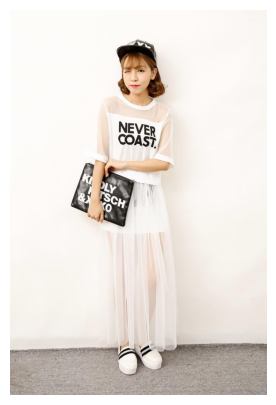

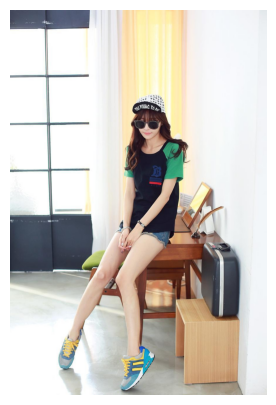

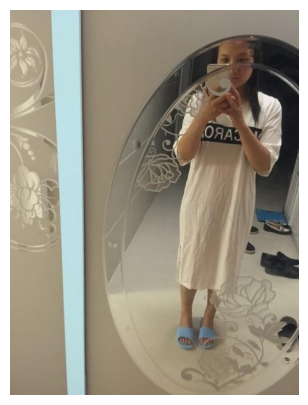

In [7]:
random_files = sample(os.listdir(img_dir), 10)

with mp_pose.Pose(static_image_mode=True, min_detection_confidence=min_conf) as pose:
    for file in random_files:
        image = mpimg.imread(os.path.join(img_dir, file))

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.pose_landmarks is None:
            continue

        if is_full_shot(results):
            plt.figure(figsize=(5, 5))
            plt.axis("off")
            plt.imshow(image)
            plt.show()

## Non full shot images

In [8]:
random_files = sample(os.listdir(img_dir), 10)

with mp_pose.Pose(static_image_mode=True, min_detection_confidence=min_conf) as pose:
    for file in random_files:
        if not os.path.exists(img_dir + file):
            continue
        image = mpimg.imread(os.path.join(img_dir, file))

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.pose_landmarks is None:
            continue

        if not is_full_shot(results):
            plt.figure(figsize=(6, 6))
            plt.axis("off")
            plt.imshow(image)
            plt.show()

## Full shot detection on whole DeepFashion2 dataset

In [13]:
full_shot_images = []

with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
    for file in tqdm(os.listdir(img_dir)):
        image = mpimg.imread(os.path.join(img_dir, file))

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.pose_landmarks is None:
            os.remove(os.path.join(img_dir, file))
            os.remove(os.path.join(ann_dir, file.split(".")[0] + ".json"))
            continue

        if not is_full_shot(results):
            os.remove(os.path.join(img_dir, file))
            os.remove(os.path.join(ann_dir, file.split(".")[0] + ".json"))
            continue

        image_height, image_width, _ = image.shape
        full_shot_images.append(
            {"id": file, "height": image_height, "width": image_width}
        )

full_shot_df = pd.DataFrame(full_shot_images)
print(full_shot_df.head(8))

100%|██████████| 32153/32153 [21:41<00:00, 24.71it/s]

           id  height  width
0  000001.jpg     624    468
1  000002.jpg     624    468
2  000008.jpg     400    225
3  000014.jpg     832    468
4  000015.jpg     351    468
5  000016.jpg     832    468
6  000036.jpg     832    468
7  000050.jpg     624    468


In [14]:
# Saving all full shot annotated images' data in a csv
full_shot_df.to_csv('FullShot.csv')